# <center> Идентификация пользователей по посещенным веб-страницам
    
### Сергей Кузьмин 14.03.2021
    
   В этом проекте решается задача идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду.
    
   Решается следующая задача: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

# <center>1. Подготовка данных к анализу и построению моделей
   Первая часть проекта посвящена подготовке данных для дальнейшего описательного анализа и построения прогнозных моделей.

In [15]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import math

In [2]:
# путь к данным
PATH_TO_DATA = '' 

In [6]:
# исходные данные
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, '10users/user0031.csv'))
user31_data.head(3)

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net


**Поставим задачу классификации: идентифицировать пользователя по сессии из 10 подряд посещенных сайтов. Объектом в этой задаче будет сессия из 10 сайтов, последовательно посещенных одним и тем же пользователем, признаками – индексы этих 10 сайтов (чуть позже здесь появится "мешок" сайтов, подход Bag of Words). Целевым классом будет id пользователя.**

## Подготовка обучающей выборки

Функция *prepare_train_set* принимает на вход путь к каталогу с csv-файлами *path_to_csv_files* и параметр *session_length* – длину сессии, а возвращает 2 объекта:
- DataFrame, в котором строки соответствуют уникальным сессиям из *session_length* сайтов, *session_length* столбцов – индексам этих *session_length* сайтов и последний столбец – ID пользователя
- частотный словарь сайтов вида {'site_string': [site_id, site_freq]}

In [51]:
def prepare_train_set(path_to_csv_files, session_length=10):
    
    glob1 = glob(os.path.join(path_to_csv_files, '*.csv'))
# создание частотного словаря сайтов    
    def in_dictionary(key, dict):
        return key in dict

    freq_dict = {}
    k = 1
    s = 1

    for file in glob1:
        df = pd.read_csv(file)
        
        for i in range(len(df.site)):
            if in_dictionary(df.site[i],freq_dict) == True:
                k = freq_dict[df.site[i]][1] + 1
                s = freq_dict[df.site[i]][0]
        
            freq_dict[df.site[i]] = [s, k]
            k = 1
            s = len(freq_dict) + 1
# создание dataframe
    word = 'site'
    number = list(range(1,session_length+1))
    columns = []
    for i in number:
        columns.append("{}{}".format(word, i))
    columns.append('user_id')
    sum1 = 0
    for file in glob1:
        df = pd.read_csv(file)
        sum1 = len(df) + sum1
        sum2 = math.ceil(sum1/session_length + len(glob1))
    
    data = pd.DataFrame(index=range(sum2), columns=columns)
# заполнение dataframe
    s = 0
    j = 0
    list2 = []
    user = 1
    for file in glob1:
        df = pd.read_csv(file)
        for i in range(len(df.site)):
            list2.append(freq_dict[df.site[i]][0])
            s += 1
            if s == 10:
                list2.append(user)
                data.iloc[j] = list2
                j += 1
                list2 = []
                s = 0
            if (i == len(df.site)-1) and (len(df.site)%10 != 0):
                for g in range(10-s):
                    list2.append(0)
                list2.append(user)    
                data.iloc[j] = list2
                j += 1
                list2 = []
                s = 0
        user += 1
    data.dropna(inplace=True)
    return data, freq_dict

In [55]:
# применение фукции prepare_train_set на данных по 10 пользователям
path_to_csv_files_10 = '/10users/'
train_data_10users, site_freq_10users = prepare_train_set(path_to_csv_files_10, session_length=10)

In [56]:
# применение фукции prepare_train_set на данных по 150 пользователям
path_to_csv_files_150 = '/150users/'
train_data_150users, site_freq_150users = prepare_train_set(path_to_csv_files_150, session_length=10)

In [57]:
# топ 10 самых поопулярных сайтов среди посещенных 150 пользователями
list_d = sorted(site_freq_150users.items(), key=lambda item:item[1][1], reverse=True)
top10_popular = []
for i in range(10):
     top10_popular.append(list_d[i][0])
print(top10_popular)

['www.google.fr', 'www.google.com', 'www.facebook.com', 'apis.google.com', 's.youtube.com', 'clients1.google.com', 'mail.google.com', 'plus.google.com', 'safebrowsing-cache.google.com', 'www.youtube.com']


## Работа с разреженным форматом данных
*Если так подумать, то полученные признаки *site1*, ..., *site10* смысла не имеют как признаки в задаче классификации. А вот если воспользоваться идеей мешка слов из анализа текстов – это другое дело. Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$. Делать это будем с помощью разреженных матриц Scipy – csr_matrix.**

In [18]:
# из документации Scipy – csr_matrix
def sparse(docs):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            if term == 0:
                break
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))

    X_sparse = csr_matrix((data, indices, indptr), dtype=int)
    return X_sparse

##  Подготовка нескольких обучающих выборок для сравнения

Пока мы брали последовательности из 10 сайтов, и это было наобум. Давайте сделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться. 

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в табличке ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

Функция *prepare_sparse_train_set_window*.

Аргументы:
- *path_to_csv_files* – путь к каталогу с csv-файлами
- *site_freq_path* – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта
- *session_length* – длина сессии (параметр)
- *window_size* – ширина окна (параметр) 

Функция возвращает 2 объекта:
- разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
- вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*

In [58]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
# считывание данных и создание dataframe
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    glob1 = glob(os.path.join(path_to_csv_files, '*.csv'))
    
    word = 'site'
    number = list(range(1,session_length+1))
    columns = []
    for i in number:
        columns.append("{}{}".format(word, i))
    columns.append('user_id')
    sum1 = 0
    for file in glob1:
        df = pd.read_csv(file)
        sum1 = len(df) + sum1
        sum2 = math.ceil(sum1/window_size + len(glob1))
    data = pd.DataFrame(index=range(sum2), columns=columns)
# заполнение dataframe
    s = 0
    s1 = 0
    j = 0
    list2 = []
    user = 1
    for file in glob1:
        df = pd.read_csv(file)
        i = 0    
        while i < len(df.site):    
            list2.append(site_freq[df.site[i]][0])
            s += 1
            if (s == session_length) and (i != len(df.site)-1):
                list2.append(user)
                data.iloc[j] = list2
                j += 1
                list2 = []
                s = 0
                i = i - (session_length - window_size)
            if (i == len(df.site)-1):
                for g in range(session_length - s):
                    list2.append(0)
                    s1 += 1
                list2.append(user)
                data.iloc[j] = list2
                j += 1
                list2 = []
                if s > window_size:
                    i = i + s1 - (session_length - window_size)
                    s = 0
                    s1 = 0
            i += 1
        s = 0
        s1 = 0
        user += 1
    data.dropna(inplace=True)
# получение разреженных матриц
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X_sparse = sparse(X)
    return X_sparse, y

In [60]:
# применяем созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150),
# значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра 
# *window_size* (10, 7 или 5)
import itertools

data_lengths = []

num_users = 10

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length) != (10, 10): 
        X_sparse_10, y_10 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'10users'), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'),
                                       session_length, window_size)
        data_lengths.append(len(y_10))         
        with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_{}users_s{}_w{}.pkl'.format(num_users,session_length,window_size)), 'wb') as X10_pkl:
            pickle.dump(X_sparse_10, X10_pkl, protocol=2)
                    
        with open(os.path.join(PATH_TO_DATA, 
                       'y_{}users_s{}_w{}.pkl'.format(num_users,session_length,window_size)), 'wb') as y10_pkl:
            pickle.dump(y_10, y10_pkl, protocol=2)

In [63]:
# для 150 пользователей
import itertools
num_users = 150
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length and (window_size, session_length) != (10, 10):
        X_sparse_150, y_150 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'150users'), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'),
                                       session_length, window_size)
        data_lengths.append(len(y_150))
        with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_{}users_s{}_w{}.pkl'.format(num_users,session_length,window_size)), 'wb') as X10_pkl:
            pickle.dump(X_sparse_150, X10_pkl, protocol=2)    
        with open(os.path.join(PATH_TO_DATA, 
                       'y_{}users_s{}_w{}.pkl'.format(num_users,session_length,window_size)), 'wb') as y10_pkl:
            pickle.dump(y_150, y10_pkl, protocol=2)

## Первичный анализ данных, проверка гипотез

In [28]:
#Считаем в DataFrame подготовленный ранее файл `train_data_10users.csv`
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')
train_df.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,1,2,3,4,3,3,4,3,5,3,1
1,6,7,8,9,3,10,11,12,13,14,1
2,14,4,14,14,15,16,6,17,18,14,1


In [30]:
# распределение целевого класса
train_df['user_id'].value_counts()

7     2796
3     2204
8     1868
6     1712
9     1643
2     1022
4      802
1      760
5      720
10     534
Name: user_id, dtype: int64

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [31]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

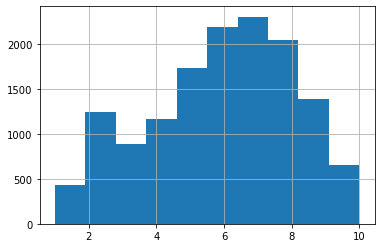

In [32]:
pd.Series(num_unique_sites).hist();

In [34]:
from scipy import stats
# проверка с помощью критерия Шапиро-Уилка, что величина распределена нормально
shapiro_test = stats.shapiro(num_unique_sites)
shapiro_test

ShapiroResult(statistic=0.9546933174133301, pvalue=0.0)

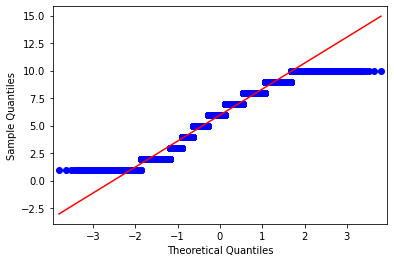

In [37]:
import statsmodels.api as sm
from matplotlib import pyplot as plt
# проверка нормальности с помощью QQ-плота
num_unique_sites11 = np.array(num_unique_sites)
fig = sm.qqplot(num_unique_sites11, line='s')
plt.show()

По результатам тестов видно, что величина распределена не нормально

Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [44]:
site_freqs = []
for i in range(train_df.values.shape[0]):
    for j in range(train_df.values.shape[1]):
         if train_df.values[i][j] >= 1000:
                site_freqs.append(train_df.values[i][j])
nn = train_df[train_df >= 1000]

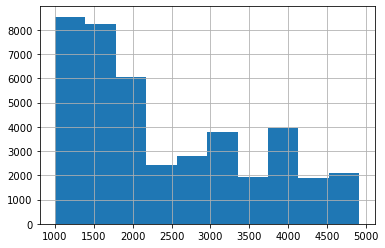

In [45]:
pd.Series(site_freqs).hist();

# <center>2. Визуальный анализ данных и построение признаков

**Создадим на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), со следующими признаками**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame

In [66]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):   
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    glob1 = glob(os.path.join(path_to_csv_files, '*.csv'))
    
    word = 'site'
    number = list(range(1,session_length+1))
    columns = []
    for i in number:
        columns.append("{}{}".format(word, i))
# добавление новых признаков
    columns.append('session_timespan')
    columns.append('#unique_sites')
    columns.append('start_hour')
    columns.append('day_of_week')
    columns.append('user_id')
    sum1 = 0
    for file in glob1:
        df = pd.read_csv(file)
        sum1 = len(df) + sum1
        sum2 = math.ceil(sum1/window_size + len(glob1))
    data = pd.DataFrame(index=range(sum2), columns=columns)

    s = 0
    s1 = 0
    j = 0
    list2 = []
    for file in glob1:
        df = pd.read_csv(file)
        user = int(file[-8:-4])
        df['timestamp'] = pd.to_datetime(df.timestamp)
        i = 0    
        while i < len(df.site):    
            list2.append(site_freq[df.site[i]][0])
            s += 1
            if (s == session_length) and (i != len(df.site)-1):
# вычисление новых признаков
                unique_sites = len(np.unique(list2))
                session_timespan = int((df.timestamp[i] - df.timestamp[i-session_length+1]).total_seconds())
                day_of_week = datetime.isoweekday(df.timestamp[i-session_length+1])
                list2.append(session_timespan)
                list2.append(unique_sites)
                list2.append(df.timestamp.dt.hour[i-session_length+1])
                list2.append(day_of_week)
                list2.append(user)
                data.iloc[j] = list2         
                j += 1
                list2 = []
                s = 0
                i = i - (session_length - window_size)
            if (i == len(df.site)-1):
                unique_sites = len(np.unique(list2))
                for g in range(session_length - s):
                    list2.append(0)
                    s1 += 1
                session_timespan = int((df.timestamp[i] - df.timestamp[i-(session_length-s1)+1]).total_seconds())
                day_of_week = datetime.isoweekday(df.timestamp[i-(session_length-s1)+1])
                list2.append(session_timespan)
                list2.append(unique_sites)
                list2.append(df.timestamp.dt.hour[i-(session_length-s1)+1])
                list2.append(day_of_week)
                list2.append(user)
                data.iloc[j] = list2
                j += 1
                list2 = []
                if s > window_size:
                    i = i + s1 - (session_length - window_size)
                    s = 0
                    s1 = 0
            i += 1
        s = 0
        s1 = 0
        user += 1
    data.dropna(inplace=True)
    
    return data

In [68]:
from datetime import datetime
from datetime import timedelta
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_toy.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,5,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,5,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,5,2


In [69]:
# для 10 пользователей
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_10users.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,5,31
1,6,7,8,9,3,10,11,12,13,14,284,10,8,5,31
2,14,4,14,14,15,16,6,17,18,14,258,7,8,5,31


In [70]:
# для 150 пользователей
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

## Визуальный анализ данных

In [72]:
# зададим для пользователей имена и ассоциируем их с цветами для визуализации
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

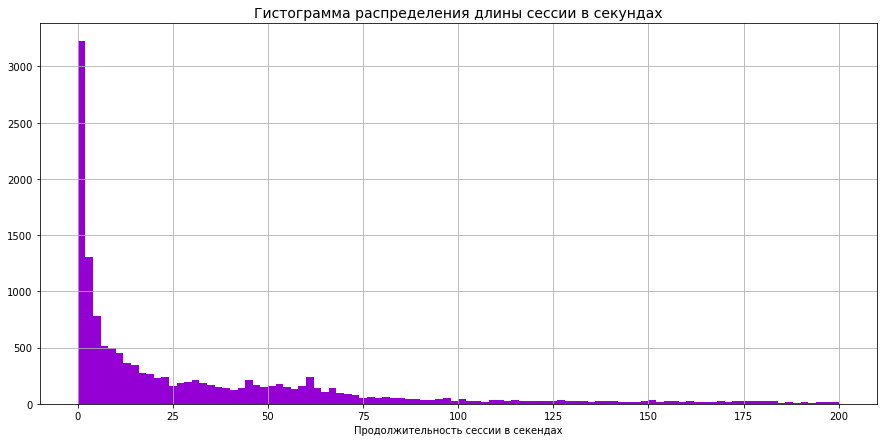

In [73]:
# построим гистограмму распределения длины сессии в секундах
fig, ax = plt.subplots(figsize=(15, 7))
kwargs ={"color":"darkviolet"}
plt.xlabel('Продолжительность сессии в секeндах')
plt.title('Гистограмма распределения длины сессии в секундах',fontsize=14)
((train_data_10users['session_timespan'].values <= 200)*train_data_10users['session_timespan']).hist(bins=100, **kwargs)
plt.show()

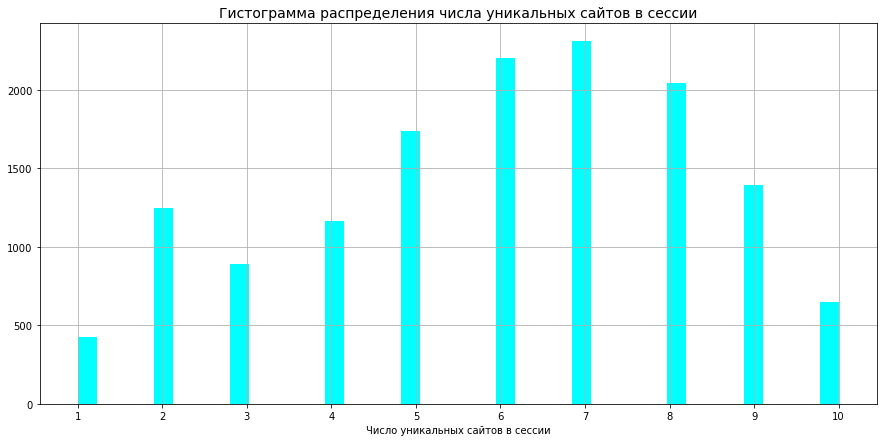

In [75]:
# построим гистограмму распределения числа уникальных сайтов в сессии
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(15, 7))
plt.xlabel('Число уникальных сайтов в сессии')
plt.title('Гистограмма распределения числа уникальных сайтов в сессии',fontsize=14)
kwargs ={"color":"aqua"}
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
train_data_10users['#unique_sites'].hist(bins=40, **kwargs)

Populating the interactive namespace from numpy and matplotlib


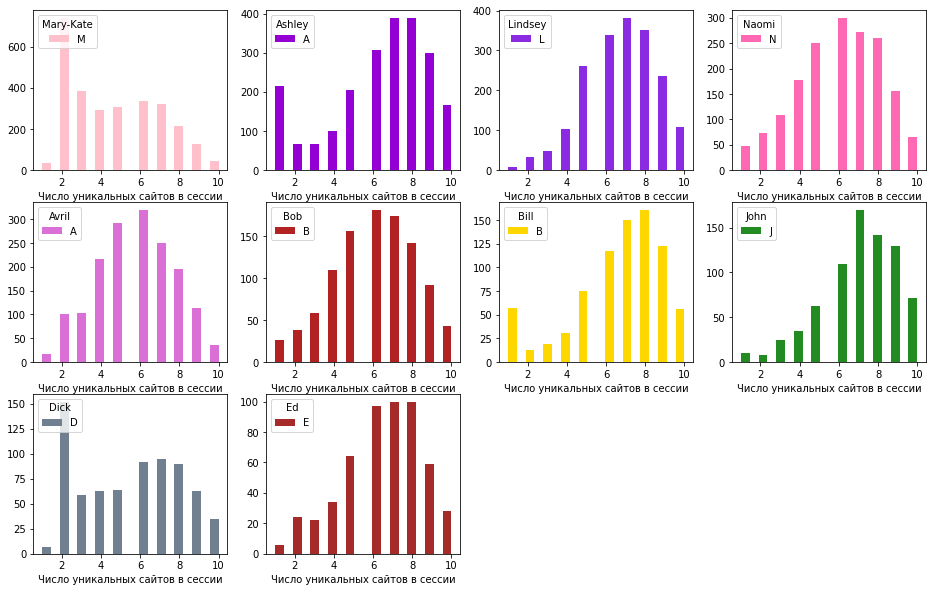

In [76]:
# Постройте гистограммы распределения числа уникальных сайтов в сессии 
# (#unique_sites) для каждого из 10 пользователей по отдельности
%pylab inline
pyplot.figure(figsize(16,10))

user_list = ['Mary-Kate', 'Ashley', 'Lindsey', 'Naomi', 'Avril', 'Bob', 'Bill', 'John', 'Dick', 'Ed']

plot_number = 0
for user in user_list:
    plot_number += 1
    pyplot.subplot(3,4,plot_number)
    pyplot.hist(train_data_10users[train_data_10users.user_id == user]['#unique_sites'],color=color_dic[user], bins=20)
    pyplot.xlabel('Число уникальных сайтов в сессии')
    pyplot.legend(user,title=user, loc='upper left')

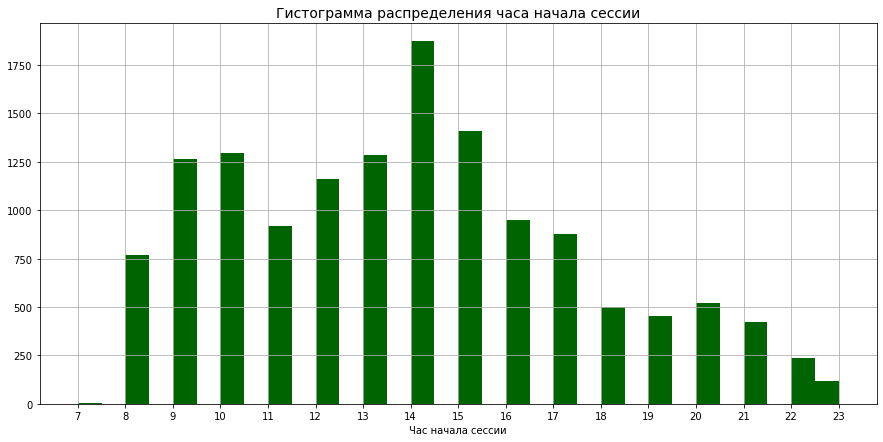

In [77]:
# построим гистограмму распределения часа начала сессии
fig, ax = plt.subplots(figsize=(15, 7))
plt.xlabel('Час начала сессии')
plt.title('Гистограмма распределения часа начала сессии',fontsize=14)
kwargs ={"color":"darkgreen"}
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
train_data_10users['start_hour'].hist(bins=32, **kwargs)

Populating the interactive namespace from numpy and matplotlib


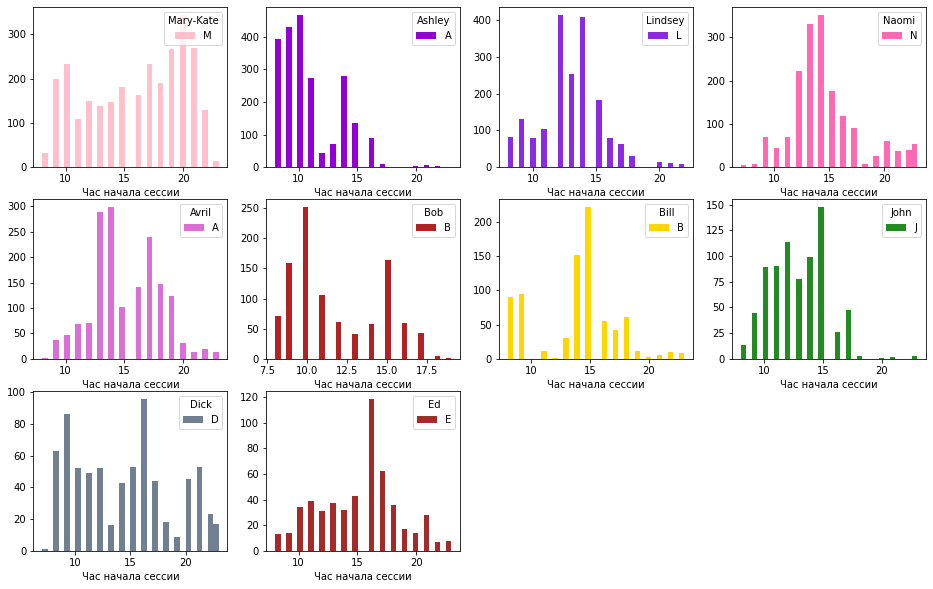

In [78]:
# Постройте гистограммы распределения часа начала сессии 
# (start_hour) для каждого из 10 пользователей по отдельности
%pylab inline
pyplot.figure(figsize(16,10))

user_list = ['Mary-Kate', 'Ashley', 'Lindsey', 'Naomi', 'Avril', 'Bob', 'Bill', 'John', 'Dick', 'Ed']

plot_number = 0
for user in user_list:
    plot_number += 1
    pyplot.subplot(3,4,plot_number)
    pyplot.hist(train_data_10users[train_data_10users.user_id == user]['start_hour'],color=color_dic[user],bins=32)
    pyplot.xlabel('Час начала сессии')
    pyplot.legend(user,title=user, loc='upper right')

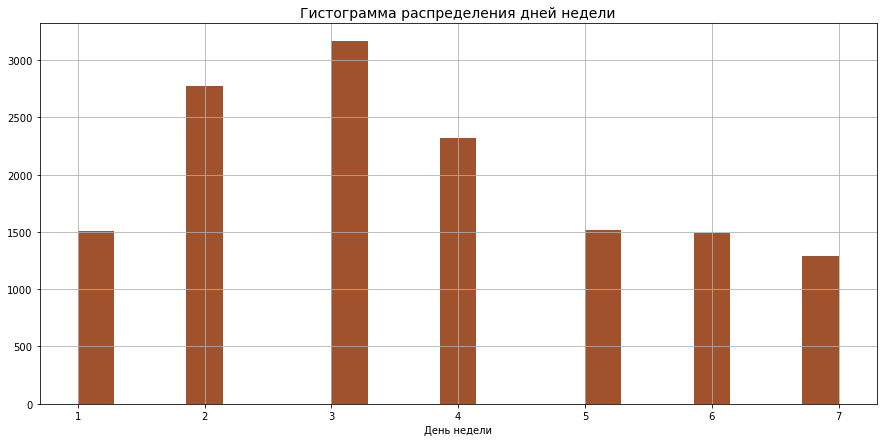

In [79]:
# построим гистограмму распределения дня недели, в которых началась сессия (day_of_week)
fig, ax = plt.subplots(figsize=(15, 7))
plt.xlabel('День недели')
plt.title('Гистограмма распределения дней недели',fontsize=14)
kwargs ={"color":"sienna"}
train_data_10users['day_of_week'].hist(bins=21, **kwargs)

Populating the interactive namespace from numpy and matplotlib


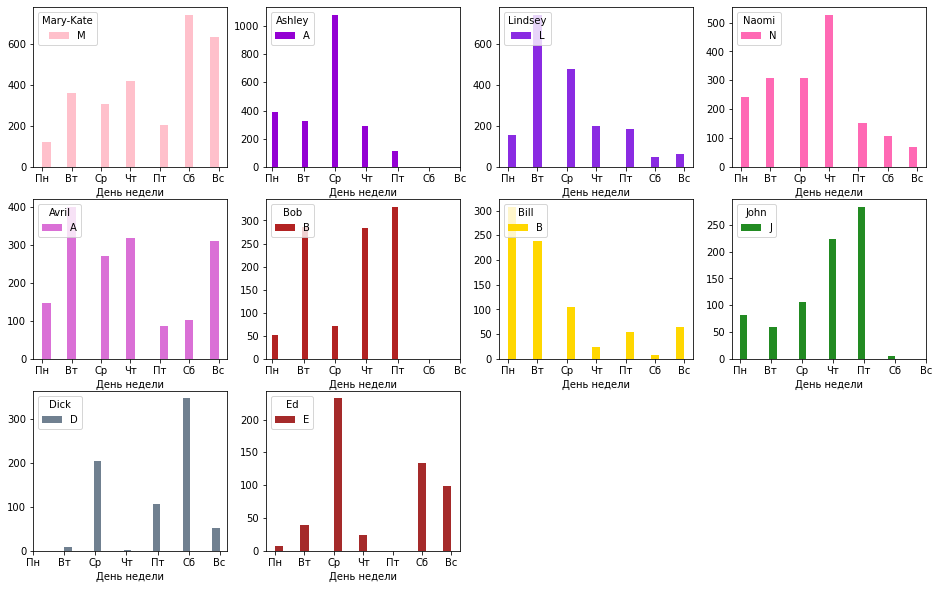

In [80]:
# Постройте гистограммы распределения дня недели, в которых началась сессия (day_of_week) 
# для каждого из 10 пользователей по отдельности
%pylab inline
pyplot.figure(figsize(16,10))

user_list = ['Mary-Kate', 'Ashley', 'Lindsey', 'Naomi', 'Avril', 'Bob', 'Bill', 'John', 'Dick', 'Ed']

plot_number = 0
for user in user_list:
    plot_number += 1
    pyplot.subplot(3,4,plot_number)
    hist(train_data_10users[train_data_10users.user_id == user]['day_of_week'],color=color_dic[user],bins=21)
    xticks(np.arange(1,8), ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'))
    pyplot.xlabel('День недели')
    pyplot.legend(user,title=user, loc='upper left')

Исходя из визуального анализа можно сделать следующие выводы:

   Пользователи практически не начинают сессию в период с 23 вечера до 8 утра. Активность пользователей во вт, ср и чт сравнительно выше других дней.
    John: Начинает сессию в основном в первой половине дня, посещает преимущественно разные сайты за сессию, в выходные не посещает никакие сайты.
    Bob: Начинает сессию в основном в пределах (возможно) рабочего дня с 8 до 18, посещает в среднем 5 уникальных сайтов за сессию, в выходные полностью не активен.
    Ashley: Начинает сессию в основном в первой половине дня, в выходные полностью не активна.
    Bill: Начало сессии в основном приходится на утро (7-9 часов) и день (14-15), основная активность приходится на пн и вт, в выходные также посещает сайты.
    Dick: Активен в среднем в течении всего светового дня, посещает различное количество уникальных сайтов за сессию, основная активность приходится на ср, пт и выходные дни.
    Naomi : Начинает сессию преимущественно днем (с 12 до 16), активна в течении всей недели.
    Mary-Kate: Активна в среднем в течении всего светового дня, часто посещает в районе 2 уникальных сайтов за сессию, активна в течении всей недели.
    Linsdey: Начинает сессию преимущественно днем (с 12 до 15), редко посещает одинаковые сайты, активна по большей части в течении всей недели, основная активность приходится на вт и ср.
    Avril: В основном начинает сессию во время рабочего дня, в среднем посещает 5 уникальных сайтов за сессию, активна в течении всей недели.
    Ed: Активен в среднем в течении всего светового дня (пик приходится на 16 часов), посещает много уникальных сайтов за сессию, практически отсутствует активность в пн и чт.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

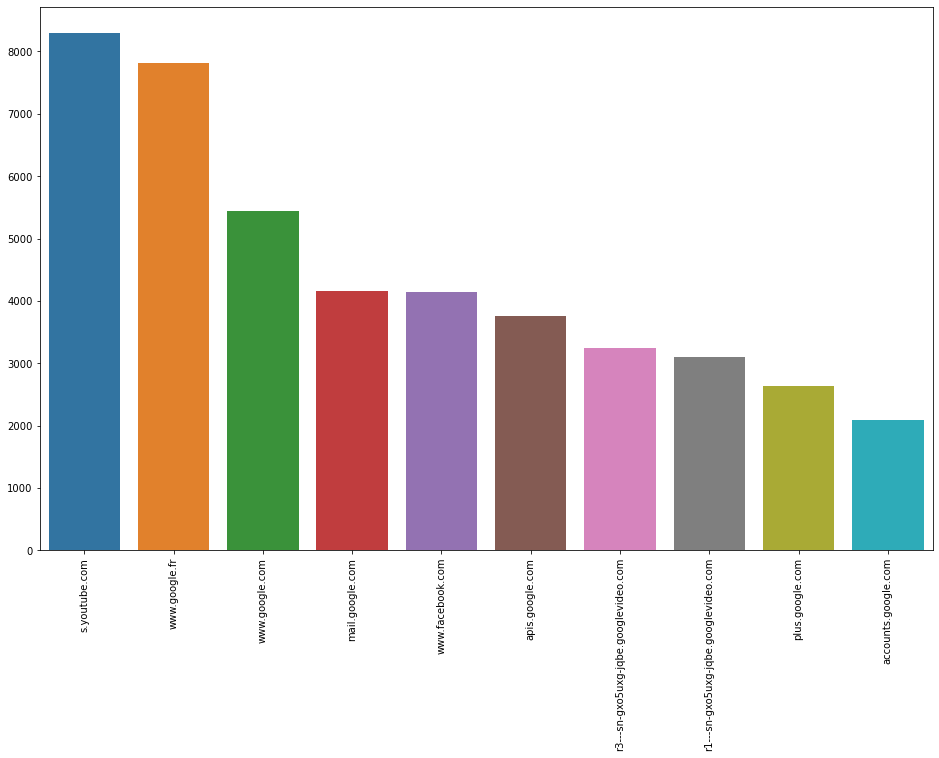

In [83]:
# нарисуем seaborn barplot, показывающий частотты посещения топ 10 сайтов
import seaborn as sns
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as f:
        site_freq = pickle.load(f)
list_d = sorted(site_freq.items(), key=lambda item:item[1][1], reverse=True)
top10_freqs = []
top10_sites =[]
for i in range(10):
    top10_sites.append(list_d[i][0])
    top10_freqs.append(list_d[i][1][1])   
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation='vertical')

# <center>3. Сравнение алгоритмов классификации

In [87]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [85]:
# Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей
# выборке для 10 пользователей.
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

X_sparse_10users.shape

(14061, 4913)

In [88]:
# Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, 
# на второй – оценивать модель, обученную после кросс-валидации.
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)
y_train = y_train.astype('int')
y_valid = y_valid.astype('int')

In [89]:
# Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [90]:
# Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Обучим случайный лес (`RandomForestClassifier`) из 100 деревьев. Посмотрим на OOB-оценку и на долю правильных ответов на выборке `(X_valid, y_valid)`.

In [91]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, oob_score=True, n_jobs=-1, random_state=17) 
scores = cross_val_score(forest, X_train, y_train, cv=skf)
scores.mean()

0.7160138255984815

In [94]:
# посчитаем долю правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке 
# и на отложенной выборке. 
forest_otl = RandomForestClassifier(n_estimators = 100, oob_score=True, n_jobs=-1, random_state=17)
forest_otl.fit(X_train, y_train)
predictions = forest_otl.predict(X_valid) 
accuracy_score(y_valid, predictions)

0.7350082958046931

Обучим логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации  и на выборке `(X_valid, y_valid)`. 

In [95]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logit = LogisticRegression(random_state=17,n_jobs=-1)
log_score = cross_val_score(logit, X_train, y_train, cv=skf).mean()
log_score

0.7606189739891912

In [96]:
logit.fit(X_train, y_train)
log_score_valid = accuracy_score(y_valid, logit.predict(X_valid))
log_score_valid

0.7767243422611994

С помощью `LogisticRegressionCV` подберем параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2. Укажим у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17.

Нарисуем кривые валидации по параметру `C`.

In [97]:
logit_c_values1 = np.logspace(-4, 2, 10)
logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17) 
logit_grid_searcher1.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     multi_class='multinomial', random_state=17)

In [98]:
%%time
logit_mean_cv_scores1 = []
logit_mean_cv_scores2 = []
for c in logit_c_values1:
    logit_c = LogisticRegression(C=c,random_state=17,n_jobs=-1)
    log_score_c = cross_val_score(logit_c, X_train, y_train, cv=skf).mean()
    logit_mean_cv_scores2.append([log_score_c, c])
    logit_mean_cv_scores1.append(log_score_c)

Wall time: 15.1 s


In [99]:
# лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.
best_score_logit_c = sorted(logit_mean_cv_scores2, reverse=True)
print(round(best_score_logit_c[0][0],3),best_score_logit_c[0][1])

0.761 1.0


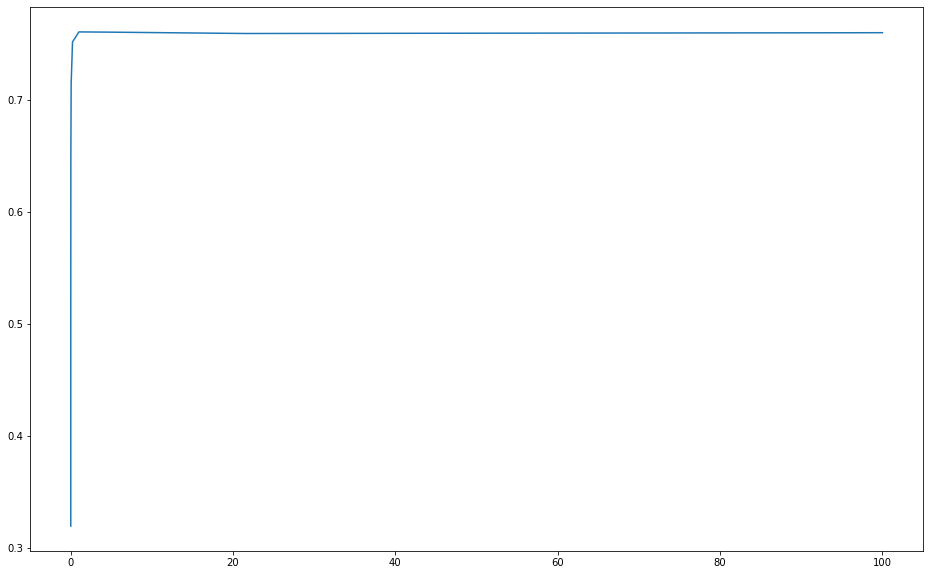

In [100]:
# нарисуем график зависимости доли правильных ответов на кросс-валидации от `C`.
plt.plot(logit_c_values1, logit_mean_cv_scores1);

Теперь то же самое, для значения параметра `C` в диапазоне `np.linspace`(0.1, 7, 20).

In [101]:
logit_c_values2 = np.linspace(0.1, 7, 20)
logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', random_state=17) 
logit_grid_searcher2.fit(X_train, y_train)
logit_grid_searcher2.Cs_[10]

3.7315789473684213

In [110]:
# Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.
logit_mean_cv_scores3 = []
logit_mean_cv_scores4 = []
for c in logit_c_values2:
    logit_c = LogisticRegression(C=c,random_state=17,n_jobs=-1)
    log_score_c = cross_val_score(logit_c, X_train, y_train, cv=skf).mean()
    logit_mean_cv_scores4.append([log_score_c, c])
    logit_mean_cv_scores3.append(log_score_c)

In [111]:
# лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.
best_score_logit_c2 = sorted(logit_mean_cv_scores4, reverse=True)
print(round(best_score_logit_c2[0][0],3),best_score_logit_c2[0][1])
best_c = best_score_logit_c2[0][1]
best_c

0.763 2.278947368421053


2.278947368421053

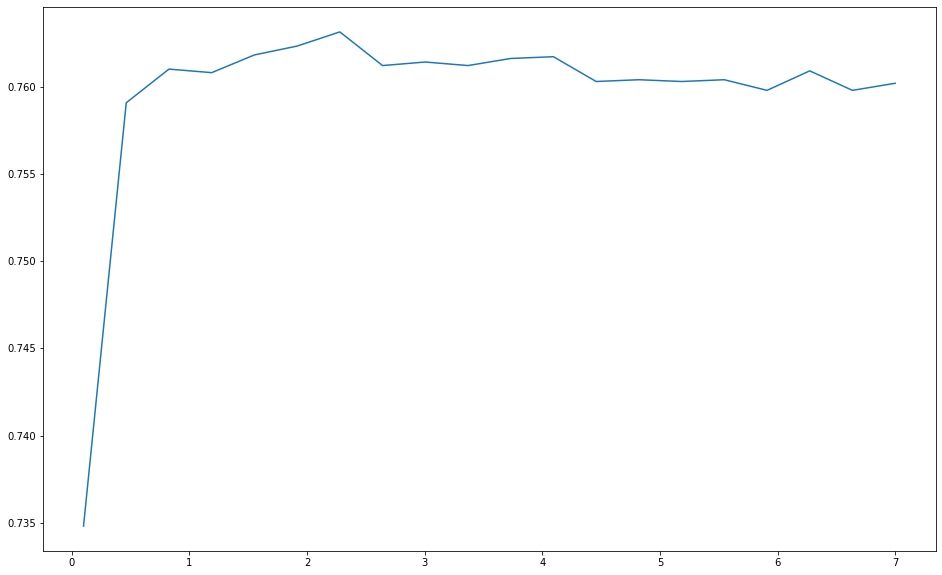

In [112]:
# нарисуем график зависимости доли правильных ответов на кросс-валидации от `C`.
plt.plot(logit_c_values2, logit_mean_cv_scores3);

In [113]:
# вычислим долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии
# с лучшим найденным значением `C`
logit_best = LogisticRegression(C=best_c, random_state=17,n_jobs=-1)
logit_best.fit(X_train, y_train)
logit_cv_acc = accuracy_score(y_valid, logit_best.predict(X_valid))
logit_cv_acc

0.7826499170419531

In [114]:
# посчитаем доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего 
# значения параметра `C` и на отложенной выборке.
logit_best_cros_val = LogisticRegression(C=best_c, random_state=17,n_jobs=-1)
logit_cv_cross_val_score = cross_val_score(logit_best_cros_val, X_train, y_train, cv=skf).mean()
logit_cv_cross_val_score

0.7631589739396327

Обучим линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`.**

In [115]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=1, random_state=17)
score_linear = cross_val_score(svm, X_valid, y_valid, cv=skf).mean()
score_linear

0.7101207368292993

С помощью `GridSearchCV` подберем параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4. Нарисуем кривые валидации.

In [116]:
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}
svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)
svm_grid_searcher1.best_score_

0.6952843773612952

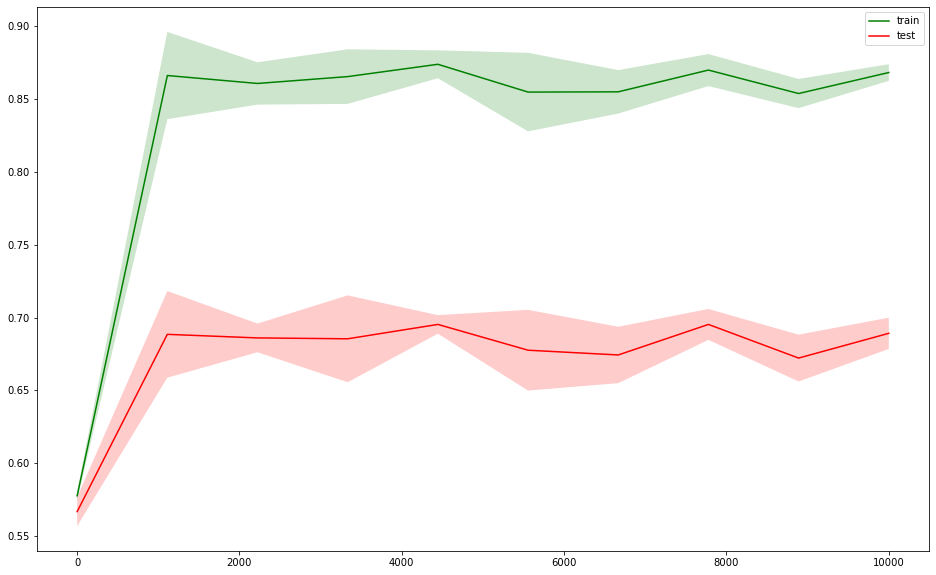

In [117]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`.

С помощью `GridSearchCV` подберем параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений. Нарисуем кривые валидации.**

In [118]:
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True)

In [119]:
# лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_)
best_c_svm = svm_grid_searcher2.best_params_['C']
best_c_svm

0.7701686093803548 {'C': 0.10434482758620689}


0.10434482758620689

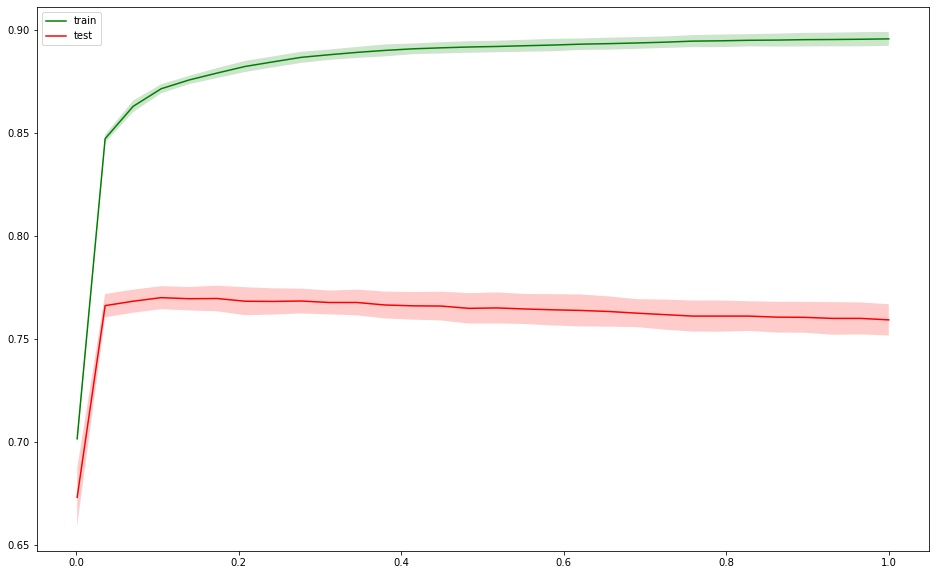

In [120]:
# график зависимости доли правильных ответов на кросс-валидации от С
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

In [121]:
# доля правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным 
# значением `C
svm_best_c1 = LinearSVC(C=best_c_svm, random_state=17)
svm_best_c1.fit(X_train, y_train)
svm_cv_acc = accuracy_score(y_valid, svm_best_c1.predict(X_valid))
round(svm_cv_acc,3)

0.781

In [122]:
# Посчитаем доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения
# параметра `C` и на отложенной выборке.
svm_best_c2 = LinearSVC(C=best_c_svm, random_state=17)
svm_cv_acc2 = cross_val_score(svm_best_c2, X_train, y_train, cv=skf).mean()
round(svm_cv_acc2,3)

0.767

## Выбор параметров – длины сессии и ширины окна

Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.

In [123]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_10users_pkl:
        X_sparse_10users = pickle.load(X_sparse_10users_pkl)
    with open(path_to_y_pickle, 'rb') as y_10users_pkl:
        y_10users = pickle.load(y_10users_pkl)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y_10users)
    y_train = y_train.astype('int')
    y_valid = y_valid.astype('int')
    
    cross_val_score1 = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    
    estimator.fit(X_train, y_train)
    acc_score2 = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return cross_val_score1, acc_score2

In [124]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                       'X_sparse_10users_s{}_w{}.pkl'.format(session_length,window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                       'y_10users_s{}_w{}.pkl'.format(session_length,window_size))
        
        result = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)                             
                                     
        print('session_length =', session_length, 'window_size =', window_size, 'result:', result)

session_length = 15 window_size = 10 result: (0.8243252292702751, 0.8404835269021095)
session_length = 10 window_size = 10 result: (0.7670206386611259, 0.7807537331121118)
session_length = 15 window_size = 7 result: (0.8495024256089474, 0.8543222166915547)
session_length = 10 window_size = 7 result: (0.7983645917156946, 0.8073668491786958)
session_length = 7 window_size = 7 result: (0.754765400423003, 0.7617388418782147)
session_length = 15 window_size = 5 result: (0.8670355547005402, 0.8752963489805595)
session_length = 10 window_size = 5 result: (0.8177520250854086, 0.8245614035087719)
session_length = 7 window_size = 5 result: (0.772939529035208, 0.7853247984826932)
session_length = 5 window_size = 5 result: (0.7254849424351582, 0.7362494073020389)
Wall time: 16 s


## Идентификация  конкретного пользователя и кривые обучения

Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.

In [125]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [126]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)
y_train_150 = y_train_150.astype('int')
y_valid_150 = y_valid_150.astype('int')

Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составим новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.

In [131]:
y_binary_128 = []
for i in range(y_150users.shape[0]):
    if y_150users[i] != 29:
        y_binary_128.append(0)
    else: 
        y_binary_128.append(1)
        
y_binary_128 = np.array(y_binary_128)

In [132]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

Посчитаем доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [133]:
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_train_150, train_sizes=train_sizes, cv=skf, n_jobs=-1)

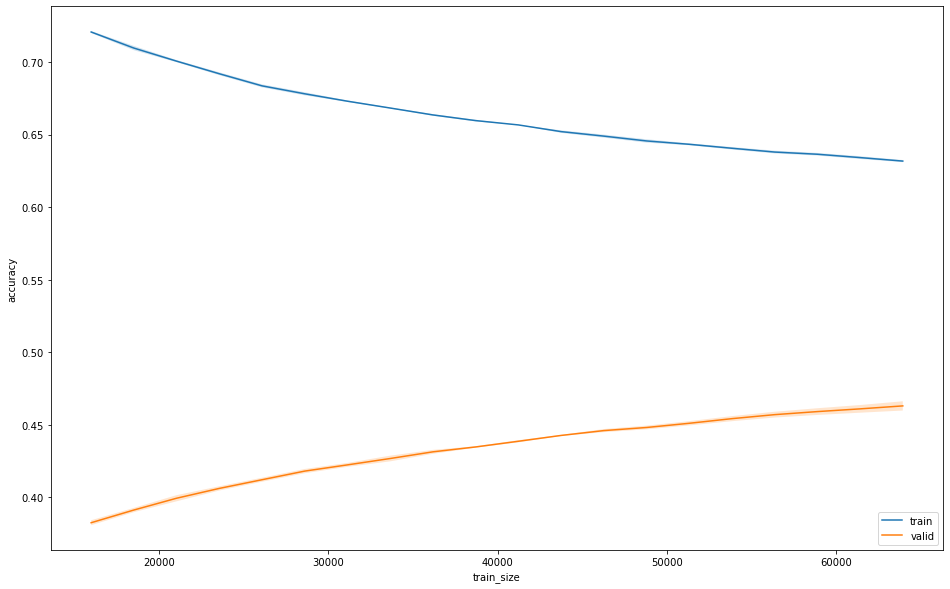

In [134]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

# <center>4. Соревнование Kaggle "Catch Me If You Can"

Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).

In [135]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [136]:
# Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их
# к разреженному формату.
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.

In [140]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Создадим функцию new_df, которая преобразовывает исходный dataframe в новый с дополнительными признаками, как это делалось ранее

In [141]:
def new_df(dataframe):
    sites = ['site' + str(i) for i in range(1, 11)]
    new_df_train = dataframe[[site for site in sites]].fillna(0).astype('int')
    new_df_train['time1'] = dataframe['time1']
    new_df_train['time'] = pd.to_datetime(new_df_train['time1'])
    del new_df_train['time1']
    
    new_df_train['day_of_week'] = np.nan
    new_df_train['start_hour'] = np.nan
    new_df_train['month'] = np.nan
    for i in range(new_df_train.shape[0]):
        new_df_train['day_of_week'].iloc[i] = datetime.isoweekday(new_df_train['time'].iloc[i])
        new_df_train['start_hour'].iloc[i] = new_df_train['time'].iloc[i].hour
        new_df_train['month'].iloc[i] = new_df_train['time'].iloc[i].month
    new_df_train['day_of_week'] = new_df_train['day_of_week'].astype('int')
    new_df_train['start_hour'] = new_df_train['start_hour'].astype('int')
    new_df_train['month'] = new_df_train['month'].astype('int')
    del new_df_train['time']
    
    return new_df_train

In [142]:
def time_df(dataframe):
    time = ['time'+str(i) for i in range(1,11)]
    time_df = dataframe[[t for t in time]]
    for i in range(time_df.shape[1]):
        time_df.iloc[:,i] = pd.to_datetime(time_df.iloc[:,i])
    time_df['delta'] = time_df.max(axis = 1) - time_df.min(axis = 1)
    return time_df

In [143]:
time_train = time_df(train_df)
time_train.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,delta
session_id,,,,,,,,,,,
1,2014-02-20 10:02:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,00:00:00
2,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16,00:00:26
3,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24,00:00:07


In [144]:
time_test = time_df(test_df)
time_test.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,delta
session_id,,,,,,,,,,,
1,2014-10-04 11:19:53,2014-10-04 11:19:53,2014-10-04 11:19:54,2014-10-04 11:19:54,2014-10-04 11:19:54,2014-10-04 11:19:54,2014-10-04 11:19:54,2014-10-04 11:19:54,2014-10-04 11:20:00,2014-10-04 11:20:00,00:00:07
2,2014-07-03 11:00:28,2014-07-03 11:00:53,2014-07-03 11:00:58,2014-07-03 11:01:06,2014-07-03 11:01:09,2014-07-03 11:01:10,2014-07-03 11:01:23,2014-07-03 11:01:29,2014-07-03 11:01:30,2014-07-03 11:01:53,00:01:25
3,2014-12-05 15:55:12,2014-12-05 15:55:13,2014-12-05 15:55:14,2014-12-05 15:56:15,2014-12-05 15:56:16,2014-12-05 15:56:17,2014-12-05 15:56:18,2014-12-05 15:56:19,2014-12-05 15:56:33,2014-12-05 15:56:36,00:01:24


In [146]:
from datetime import datetime
df_tr = new_df(train_df)
df_tr['session_timespan'] = time_train['delta'].dt.total_seconds().astype('int')
df_tr.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,day_of_week,start_hour,month,session_timespan
session_id,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,4,10,2,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518,6,11,2,26
3,14769,39,14768,14769,37,39,14768,14768,14768,14768,1,16,12,7


In [147]:
df_test = new_df(test_df)
df_test['session_timespan'] = time_test['delta'].dt.total_seconds().astype('int')
df_test.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,day_of_week,start_hour,month,session_timespan
session_id,,,,,,,,,,,,,,
1,29,35,22,321,23,2211,6730,21,44582,15336,6,11,10,7
2,782,782,782,782,782,782,782,782,782,782,4,11,7,85
3,55,55,55,55,55,55,55,55,1445,1445,5,15,12,84


In [150]:
df_tr_test = pd.concat([df_tr, df_test])
df_tr_test.shape

(336358, 14)

In [151]:
# создадим разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее.
train_test_sparse1 = sparse(df_tr_test.values)
test_size1 = len(df_test)/(len(train_df)+len(df_test))
X_train_sp, X_test_sp = train_test_split(train_test_sparse1, test_size=test_size1, shuffle=False)
y = train_df['target']

Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.

In [152]:
train_share1 = int(.7 * X_train_sp.shape[0])
X_train1, y_train1 = X_train_sp[:train_share1, :], y[:train_share1]
X_valid1, y_valid1  = X_train_sp[train_share1:, :], y[train_share1:]

Создадим объект `sklearn.linear_model.LogisticRegression`. Параметры по умолчанию.

In [153]:
logit = LogisticRegression(random_state=17,n_jobs=-1)

С помощью `RandomizedSearchCV` подберем параметр `C` для `LogisticRegression` в широком диапазоне: np.linspace(0.1, 10, 30). 

In [154]:
from sklearn.model_selection import RandomizedSearchCV
c_values1 = np.linspace(0.1, 10, 30)
random_search = RandomizedSearchCV(estimator = logit, param_distributions={'C':c_values1}, 
                                   scoring = 'roc_auc', n_jobs=-1, cv=5, verbose=1)

In [155]:
random_search.fit(X_train1, y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(n_jobs=-1, random_state=17),
                   n_jobs=-1,
                   param_distributions={'C': array([ 0.1       ,  0.44137931,  0.78275862,  1.12413793,  1.46551724,
        1.80689655,  2.14827586,  2.48965517,  2.83103448,  3.17241379,
        3.5137931 ,  3.85517241,  4.19655172,  4.53793103,  4.87931034,
        5.22068966,  5.56206897,  5.90344828,  6.24482759,  6.5862069 ,
        6.92758621,  7.26896552,  7.61034483,  7.95172414,  8.29310345,
        8.63448276,  8.97586207,  9.31724138,  9.65862069, 10.        ])},
                   scoring='roc_auc', verbose=1)

In [156]:
random_search.best_score_, random_search.best_params_

(0.9720909194683454, {'C': 1.4655172413793105})

Обучим логистическую регрессию с лучшем параметром С, найденном с помощью RandomizedSearchCV

In [157]:
logit1 = LogisticRegression(random_state=17,n_jobs=-1, C=1.4655172413793105)
logit1.fit(X_train_sp, y)
logit_test_predict = logit1.predict_proba(X_test_sp)[:,1]

Полученные ответы записываем в файл и отправляем на Kaggle

In [158]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    print(predicted_df)
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
write_to_submission_file(logit_test_predict, 
                         os.path.join(PATH_TO_DATA, 'logit_test_predict1.csv'))

Получен следующий результат на соревновании 

best score: 0.92353

Имя на leaderbord -  [YDF & MIPT] Kuzmin Sergey

## 5. Применение Vowpal Wabbit к данным по посещению сайтов

Далее посмотрим на Vowpal Wabbit в деле. Правда, в задаче нашего соревнования при бинарной классификации веб-сессий мы разницы не заметим – как по качеству, так и по скорости работы (хотя можете проверить), продемонстрируем всю резвость VW в задаче классификации на 400 классов. Исходные данные все те же самые, но выделено 400 пользователей, и решается задача их идентификации. Скачайте данные [отсюда](https://kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data) – файлы `train_sessions_400users.csv` и `test_sessions_400users.csv`.

**Загрузим обучающую и тестовую выборки. Можно заметить, что тестовые сессии здесь по времени четко отделены от сессий в обучающей выборке. **

In [162]:
train_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'train_sessions_400users.csv'), 
                           index_col='session_id')
test_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'test_sessions_400users.csv'), 
                           index_col='session_id')

Видим, что в обучающей выборке 182793 сессий, в тестовой – 46473, и сессии действительно принадлежат 400 различным пользователям.

In [164]:
train_df_400.shape, test_df_400.shape, train_df_400['user_id'].nunique()

((182793, 21), (46473, 20), 400)

Vowpal Wabbit любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 400). Поэтому придется применить `LabelEncoder`, да еще и +1 потом добавить (`LabelEncoder` переводит метки в диапозон от 0 до K-1). Потом надо будет применить обратное преобразование.

In [165]:
from sklearn.preprocessing import LabelEncoder
y = train_df_400['user_id']
class_encoder = LabelEncoder()
y_for_vw = class_encoder.fit_transform(y) + 1

Далее будем сравнивать VW с SGDClassifier и с логистической регрессией. Всем моделям этим нужна предобработка входных данных. Подготовим для sklearn-моделей разреженные матрицы, как мы это делали раньше
- объединим обучающиую и тестовую выборки
- выберем только сайты (признаки от 'site1' до 'site10')
- заменим пропуски на нули (сайты у нас нумеровались с 0)
- переведем в разреженный формат `csr_matrix`
- разобьем обратно на обучающую и тестовую части

In [166]:
train_test_df = pd.concat([train_df_400, test_df_400])
sites = ['site' + str(i) for i in range(1, 11)]
train_test_df_sites = train_test_df[[site for site in sites]].fillna(0).astype('int')

In [167]:
train_test_sparse = sparse(train_test_df_sites.values)
test_size = len(test_df_400)/(len(train_df_400)+len(test_df_400))
X_train_sparse, X_test_sparse = train_test_split(train_test_sparse, test_size=test_size, shuffle=False)

In [168]:
train_df1, test_df1 = train_test_split(train_test_df_sites, test_size=test_size, shuffle=False)

Выделим обучающую (70%) и отложенную (30%) части исходной обучающей выборки. Данные не перемешиваем, учитываем, что сессии отсортированы по времени.

In [169]:
train_share = int(.7 * train_df_400.shape[0])
train_df_part = train_df1.iloc[:train_share, :]
valid_df = train_df1.iloc[train_share:, :]
X_train_part_sparse = X_train_sparse[:train_share, :]
X_valid_sparse = X_train_sparse[train_share:, :]

In [170]:
y_train_part = y[:train_share]
y_valid = y[train_share:]
y_train_part_for_vw = y_for_vw[:train_share]
y_valid_for_vw = y_for_vw[train_share:]

Реализуем функцию, `arrays_to_vw`, переводящую обучающую выборку в формат Vowpal Wabbit.**

Вход:
 - X – матрица `NumPy` (обучающая выборка)
 - y (необяз.) - вектор ответов (`NumPy`). Необязателен, поскольку тестовую матрицу будем обрабатывать этой же функцией
 - train – флаг, True в случае обучающей выборки, False – в случае тестовой выборки
 - out_file – путь к файлу .vw, в который будет произведена запись
 
Детали:
- надо пройтись по всем строкам матрицы `X` и записать через пробел все значения, предварительно добавив вперед нужную метку класса из вектора `y` и знак-разделитель `|`
- в тестовой выборке на месте меток целевого класса можно писать произвольные, допустим, 1

In [171]:
def to_vw_format(X, label=None):    
    X_list = X.tolist()
    a = str(label or "1") + " |" + " " + " ".join(map(str, map(int, X_list))) + '\n'
    return a

In [173]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    
    if train:
        with open(out_file, "w") as vw_data:
            for i in range(X.shape[0]):
                if type(y) == numpy.ndarray:
                    vw_data.write(to_vw_format(X.iloc[i], y[i]))
                    #print('X', X.iloc[i])
                    #print(to_vw_format(X.iloc[i], y[i]))
                else:
                    vw_data.write(to_vw_format(X.iloc[i], y.iloc[i]))
                    #print(to_vw_format(X.iloc[i], y.iloc[i]))
    else:
        with open(out_file, "w") as vw_data:
            for i in range(X.shape[0]):
                vw_data.write(to_vw_format(X.iloc[i]))
                #print(to_vw_format(X.iloc[i]))
    pass

Применим написанную функцию к части обучащей выборки `(train_df_part, y_train_part_for_vw)`, к отложенной выборке `(valid_df, y_valid_for_vw)`, ко всей обучающей выборке и ко всей тестовой выборке. 

In [ ]:
arrays_to_vw(train_df_part, y_train_part_for_vw, out_file='train_part.vw')
arrays_to_vw(valid_df, y_valid_for_vw, out_file='valid.vw')
arrays_to_vw(train_df1, y_for_vw, out_file='train.vw')
arrays_to_vw(test_df1, out_file='test.vw', train=False)

Обучим модель Vowpal Wabbitна выборке `train_part.vw`. Укажим, что решается задача классификации с 400 классами (`--oaa`), сделаем 3 прохода по выборке (`--passes`).  Также укажим значение параметра `b`=26. Это число бит, используемых для хэширования, в данном случае нужно больше, чем 18 по умолчанию.

In [176]:
%%time
!vw -k -d train_part.vw --oaa 400 --passes 3 -c -b 26 --random_seed 17 -f model.vw

Wall time: 24.7 s


final_regressor = model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = train_part.vw.cache
Reading datafile = train_part.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      262        1       11
1.000000 1.000000            2            2.0       82      262       11
1.000000 1.000000            4            4.0      241      262       11
1.000000 1.000000            8            8.0      352      262       11
1.000000 1.000000           16           16.0      135       16       11
1.000000 1.000000           32           32.0       71      112       11
0.968750 0.937500           64           64.0      358      231       11
0.976562 0.984375          128          128.0      348      346       11
0.941406 0.906250          256          256.0      202     

Запишим прогнозы на выборке *valid.vw* в *vw_valid_pred.csv*.

In [177]:
!vw -d valid.vw -i model.vw -t -p pred.csv

only testing
predictions = pred.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        4      188       11
1.000000 1.000000            2            2.0      160      220       11
0.750000 0.500000            4            4.0      143      143       11
0.750000 0.750000            8            8.0      247      247       11
0.687500 0.625000           16           16.0      341       30       11
0.593750 0.500000           32           32.0      237      237       11
0.609375 0.625000           64           64.0      178      178       11
0.640625 0.671875          128          128.0      132      228       11
0.656250 0.671875          256          256.0       14       14       11
0.646484 0.636719          512   

Считаем прогнозы *kaggle_data/vw_valid_pred.csv*  из файла и посмотрим на долю правильных ответов на отложенной части.

In [178]:
pred1 = pd.read_csv('pred.csv', header=None)
vw_sc = accuracy_score(y_valid_for_vw, pred1[0].tolist())
vw_sc

0.34541741128414605

Теперь обучим `SGDClassifier` (3 прохода по выборке, логистическая функция потерь) и `LogisticRegression` на 70% разреженной обучающей выборки – `(X_train_part_sparse, y_train_part)`, сделайте прогноз для отложенной выборки `(X_valid_sparse, y_valid)` и посчитаем доли верных ответов. 

In [181]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [183]:
logit = LogisticRegression(random_state=17, n_jobs=-1, solver='liblinear')
logit.fit(X_train_part_sparse, y_train_part)
logit_valid_acc = accuracy_score(y_valid, logit.predict(X_valid_sparse))
logit_valid_acc

0.36292352018673185

In [182]:
sgd_logit = SGDClassifier(loss='log', max_iter=3, n_jobs=-1, random_state=17)
sgd_logit.fit(X_train_part_sparse, y_train_part)
sgd_valid_acc = accuracy_score(y_valid, sgd_logit.predict(X_valid_sparse))
sgd_valid_acc

0.2936467413107699

По данным результатам можно сделать следующие выводы:

Наилучшую долю правильных ответов дала модель LogisticRegression, но при этом время на обучение и прогноз для Vowpal Wabbit и SGDClassifier потребовалось сильно меньше по сравнению с LogisticRegression, а качество классификации не намного хуже.

## Выводы по проекту

Построенная модель может применятся на практике для идентификации пользователей в сети, или задачи, где необходимо идентифицировать несколько разных пользователей. Например, может применятся в бизнес-сфере таргетирования рекламы, так как по тому, какие сайты посещает пользователь, можно неплохо предсказывать, что может потребоваться данному пользователю. Также данная модель применима для вычисления злоумышленников в сети и их попыток взлома.